# Multi-Armed Bandits

This notebook works through Python implementations of the elements mentioned in Chapter 2 of Sutton and Barto, *Reinforcement Learning, An Introduction*. We use the math and random module instead of something with more functions built in like Numpy (just for the fun of it). 

In [1]:
import math
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
from tqdm import tqdm
np.seterr(divide='ignore')
%matplotlib inline

## Build the simulated environment.

Make a function to generate the possible actions, or arms, of the $k$-armed bandit problem. It is enough to generate the $q_{*}(a_{i})$ for actions $a_{1},\ldots,a_{k}$. The second function adjusts the arms for a non-stationary problem.

In [2]:
def generate_gaussian_arms(number_of_arms, 
                           mean = 0, 
                           standard_deviation = 1, 
                           arm_deviation = 1,
                           dev_mode = 'uniform_deviations',
                           mean_mode = 'gaussian'):
    # Note: uniform arms implies the standard deviation of rewards for each arms is the same.
    # Mixed arms means it is not. 
    assert dev_mode in ['uniform_deviations', 'mixed_deviations'], 'Deviation modes: uniform_deviations, mixed_deviations.' 
    assert mean_mode in ['gaussian', 'equal'], 'Deviation modes: gaussian, equal.' 
    if dev_mode == 'mixed_deviations':
        arm_deviations = [math.fabs(random.gauss(1,1)) for i in range(number_of_arms)]
    else:
        arm_deviations = [arm_deviation for i in range(number_of_arms)]
    if mean_mode == 'equal':
        arm_means = [mean for i in range(number_of_arms)]
    else:
        arm_means = [random.gauss(mean, standard_deviation) for i in range(number_of_arms)]
    return [[arm_means[i], arm_deviations[i]] for i in range(number_of_arms)]

def adjust_arms_gaussian(arms, mean = 0, standard_deviation = .01):
    return [[x + random.gauss(mean, standard_deviation), y] for [x,y] in arms]

sample_arms = generate_gaussian_arms(3)
print(sample_arms)
print(adjust_arms_gaussian(sample_arms))

sample_arms = generate_gaussian_arms(3, dev_mode = 'mixed_deviations', mean_mode = 'equal')
print(sample_arms)

[[-0.12805820108555946, 1], [0.670079440460194, 1], [0.41609745978771157, 1]]
[[-0.1334170220550943, 1], [0.6742406265414078, 1], [0.41734259424549736, 1]]
[[0, 0.2702388046704123], [0, 4.116055932114601], [0, 1.0155353776385574]]


## Make a learner.

The main characteristic of a learner is the value function, which is the set $$\{Q_{t}(a_{1}),\ldots,Q_{t}(a_{k})\}.$$ The policy is also necessary, which is the function that selects the action according to the value function, as is the learning mechanism, which is how the learner evaluates rewards and updates its value function. We also have control over initialization. We will construct a suite of attributes that our learner could possess, as is outlined in Chapter 2.  

So really our learner's brain will be a list of the $Q_{t}(a_{i}), N_{t}(a_{i})$ and we simply need functions to update that list. Also, tack on a total reward to track how the learner has performed. 

In [3]:
# Challenge: there are many inefficiencies here.  Put in an object oriented framework.

def initialize_learner(number_of_arms, 
                       mode = 'realistic', 
                       mean = 0, 
                       standard_deviation = 1, 
                       optimistic_parameter = 5):
    
    assert mode in ['realistic', 'optimistic'], 'Modes: realistic or optimistic initialization.'
    if mode == 'optimistic':
        learner = [[mean + optimistic_parameter*standard_deviation, 0] for i in range(number_of_arms)]
        learner.append(0)
    else:
        learner = [[0,0] for i in range(number_of_arms)]
        learner.append(0)
    return learner

def get_estimated_values(learner):
    return [x for [x,y] in learner[:len(learner) - 1]]

def get_number_of_attempts(learner):
    return [y for [x,y] in learner[:len(learner) - 1]]

def list_argmax(numerical_list):
    max_list = [0]
    for i in range(1,len(numerical_list)):
        if numerical_list[i] > numerical_list[max_list[0]]:
            max_list = [i]
        elif numerical_list[i] == numerical_list[max_list[0]]:
            max_list.append(i)
    return(max_list[random.randint(0,len(max_list)-1)])

def UCB_factor(step, number_of_attempts):
    if step > 0 and number_of_attempts > 0:
        return math.sqrt(math.log(step)/number_of_attempts)
    else:
        return 1
        
# We allow for an epsilon-greedy implementation of UCB.  For UCB to be used as in the text,
# mode should be set to greedy when UCB is used. 

def decide(learner, 
           step, 
           mode = 'greedy', 
           function = 'argmax', 
           epsilon = .1, 
           UCB_param = 2):
    
    assert mode in ['greedy', 'epsilon_greedy'], 'Modes: greedy or epsilon_greedy.'
    assert function in ['argmax', 'UCB'], 'Function must be argmax or UCB.'
    estimated_values = get_estimated_values(learner)
    if mode == 'epsilon_greedy':
        if random.uniform(0,1) < epsilon:
            return random.randint(0, len(estimated_values)-1)
    if function == 'UCB':
        UCB_values = [x + UCB_param*UCB_factor(step, y) for [x,y] in learner[:len(learner) - 1]]
        return list_argmax(UCB_values)
    else:
        return list_argmax(estimated_values)
    
def update_learner(learner, 
                   choice_reward, 
                   mode = 'sample_average', 
                   step_param = .1):
    
    assert mode in ['sample_average', 'constant_step', 'unbiased_constant_step'], 'Modes: sample_average, constant_step, or unbiased_constant_step.'
    index = choice_reward[0]
    reward = choice_reward[1]
    learner[index][1] += 1
    learner[-1] += reward
    if mode == 'constant_step':
        learner[index][0] = learner[index][0] + step_param * (reward - learner[index][0])
        return learner
    elif mode == 'unbiased_constant_step':
        # Need to dynamically program o_bar. 
        o_bar = 0
        for i in range(learner[index][1]):
            o_bar += o_bar + step_param * (1 - o_bar)
        beta = step_param / o_bar
        learner[index][0] = learner[index][0] + beta * (reward - learner[index][0])
        return learner
    else:
        learner[index][0] = learner[index][0] + (reward - learner[index][0])/learner[index][1]
        return learner

## Give the learner agency in the environment. 

In [4]:
def pull_arm(arms, choice):
    return random.gauss(arms[choice][0], arms[choice][1])

## Run an experiment with 1000 steps.

Run an experiment and then print the learner to see how it did, as in 2.2.

In [5]:
def get_optimal_arm(arms):
    return list_argmax([x for [x,y] in arms])

def optimal_action_ratio(step, learner, arms):
    return learner[get_optimal_arm(arms)][1] / (step + 1)

def optimal_comparison(learner, arms):
    if list_argmax(get_number_of_attempts(learner)) == get_optimal_arm(arms):
        print('The learner converged on the optimal strategy.')
        return 1
    else:
        print('The learner did not converge on the optimal strategy.')
        return 0

In [6]:
number_of_arms = 10
number_of_steps = 1000

arms = generate_gaussian_arms(number_of_arms)
learner = initialize_learner(number_of_arms, mode = 'optimistic')

# Time the experiment.
start_time = time.time()

for step in range(number_of_steps):
    choice = decide(learner, step, mode = 'epsilon_greedy', function = 'argmax')
    choice_reward = [choice, pull_arm(arms, choice)]
    learner = update_learner(learner, choice_reward)

total_time = time.time() - start_time
print('Total time: {:1.4f} seconds.'.format(total_time))
print('Total reward: {:1.4f} points.'.format(learner[-1]))
print('Total optimal action ratio: {:1.4f}'.format(optimal_action_ratio(number_of_steps - 1, learner, arms)))
optimal_comparison(learner, arms)

Total time: 0.0060 seconds.
Total reward: 1029.4517 points.
Total optimal action ratio: 0.8960
The learner converged on the optimal strategy.


1

## Chapter Coding Exercises:

### Exercise 2.5:

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_{*}(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation $0.01$ to all the $q_{*}(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed,
and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.

#### Prepare plots.

This includes a mechanism to conduct the experiments over 2000 learners and keep track of the reward at each step and whether or not the learner chose the optimal action. 

##### Note:

When running experiments, each learner was subjected to a different set of arms, and I'm not sure if this is how the book does it (it may generate a set of arms and set 2000 learners upon it).  Either way, one still sees the trends, though the data may be noisier. 

In [7]:
number_of_arms = 10
number_of_steps = 10000
number_of_experiments = 2000

# Problem-specific counters.
total_rewards_A = [0 for i in range(number_of_steps)]
total_optimal_actions_A = [0 for i in range(number_of_steps)]

total_rewards_B = [0 for i in range(number_of_steps)]
total_optimal_actions_B = [0 for i in range(number_of_steps)]

# Trial A: sample-average method.
start_time_A = time.time()

for experiment in range(number_of_experiments):
    arms = generate_gaussian_arms(number_of_arms, mean_mode = 'equal')
    learner = initialize_learner(number_of_arms)
    for step in range(number_of_steps):
        optimal_choice = get_optimal_arm(arms)
        choice = decide(learner, step, mode = 'epsilon_greedy', function = 'argmax')
        choice_reward = [choice, pull_arm(arms, choice)]
        total_rewards_A[step] += choice_reward[1]
        if choice_reward[0] == optimal_choice:
            total_optimal_actions_A[step] += 1
        learner = update_learner(learner, choice_reward)
        arms = adjust_arms_gaussian(arms)
    if experiment > 0 and experiment % 500 == 0:
        print('Trial A, experiment {:d} complete.'.format(experiment))
        

total_time_A = time.time() - start_time_A
print('Trial A complete in {:1.1f} seconds.'.format(total_time_A))

# Trial B: constant-step method.
start_time_B = time.time()

for experiment in range(number_of_experiments):
    arms = generate_gaussian_arms(number_of_arms, mean_mode = 'equal')
    learner = initialize_learner(number_of_arms)
    for step in range(number_of_steps):
        optimal_choice = get_optimal_arm(arms)
        choice = decide(learner, step, mode = 'epsilon_greedy', function = 'argmax')
        choice_reward = [choice, pull_arm(arms, choice)]
        total_rewards_B[step] += choice_reward[1]
        if choice_reward[0] == optimal_choice:
            total_optimal_actions_B[step] += 1
        learner = update_learner(learner, choice_reward, mode = 'constant_step')
        arms = adjust_arms_gaussian(arms)
    if experiment > 0 and experiment % 500 == 0:
        print('Trial B, experiment {:d} complete.'.format(experiment))

total_time_B = time.time() - start_time_B
print('Trial B complete in {:1.1f} seconds.'.format(total_time_B))

trial_A_average_rewards = [x/number_of_experiments for x in total_rewards_A]
trial_A_optimal_action_ratios = [x/number_of_experiments for x in total_optimal_actions_A]

trial_B_average_rewards = [x/number_of_experiments for x in total_rewards_B]
trial_B_optimal_action_ratios = [x/number_of_experiments for x in total_optimal_actions_B]

Trial A, experiment 500 complete.
Trial A, experiment 1000 complete.
Trial A, experiment 1500 complete.
Trial A complete in 357.5 seconds.
Trial B, experiment 500 complete.
Trial B, experiment 1000 complete.
Trial B, experiment 1500 complete.
Trial B complete in 370.5 seconds.


#### Average reward by step.

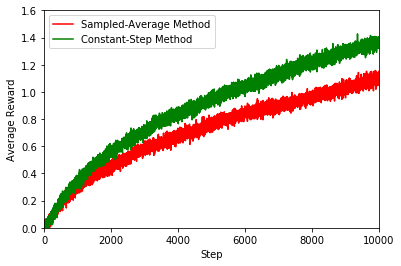

In [8]:
plt.plot(trial_A_average_rewards, 'r', label = 'Sampled-Average Method')
plt.plot(trial_B_average_rewards, 'g', label = 'Constant-Step Method')
plt.axis([0, 10000, 0, 1.6])
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

#### Percent optimal action by step.

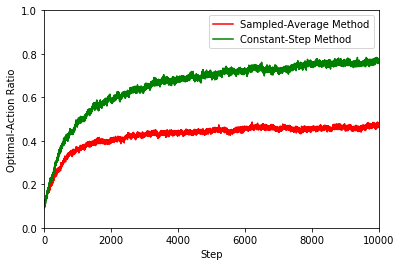

In [9]:
plt.plot(trial_A_optimal_action_ratios, 'r', label = 'Sampled-Average Method')
plt.plot(trial_B_optimal_action_ratios, 'g', label = 'Constant-Step Method')
plt.axis([0, 10000, 0, 1])
plt.xlabel('Step')
plt.ylabel('Optimal-Action Ratio')
plt.legend()
plt.show()

### Conclusions:

The constant step method clearly outperformed the sampled-average method in the non-stationary setting.

## Object-Oriented Implementation

We wrap the above into a class with the method `k_AB_Experiment.run()` producing all of the graphics and whatnot for the experiment. We'll use numpy to make arrays of learners to apply to a single problem updated in parallel.

In [10]:
# Numpy utility functions.
def np_array_argmax(array):
    # Modified argmax that chooses among ties randomly.
    max_list = [0]
    for i in range(1,len(array)):
        if array[i] > array[max_list[0]]:
            max_list = [i]
        elif array[i] == array[max_list[0]]:
            max_list.append(i)
    return max_list[int(np.random.choice(len(max_list),1))]
    
    
def np_argmax_along_rows(array):
    return np.apply_along_axis(np_array_argmax, 1, array)

# K-Armed Bandit experiment class.
class k_AB_Experiment:
    
    # Class attributes:
    problem_modes = ['stationary', 'non_stationary']
    agent_to_bandit_modes = ['many_to_one', 'one_to_one']

    def __init__(self, 
                 number_of_arms = 10,
                 number_of_agents = 1,
                 agent_to_bandit_mode = 'many_to_one',
                 q_star_mean = 0,
                 q_star_dev = 1,
                 
                 # Problem parameters.
                 problem_mode = 'stationary',
                 move_deviation = .01,
                 
                 # Bandit parameters.
                 arm_mean_mode = 'gaussian',
                 arm_dev_mode = 'uniform_deviations',
                 mixed_dev = 1,
                 mixed_mean = 1,
                 
                 # Agent parameters. 
                 agent_init_mode = 'realistic', 
                 optimistic_param = 5,
                 
                 # Decision parameters.
                 decision_mode = 'greedy',
                 decision_function = 'argmax', 
                 greedy_epsilon = .1, 
                 UCB_param = 2, 
                 
                 # Update parameters
                 update_mode = 'sample_average', 
                 step_param = .1):
        
        # Step count mainted throughout experiment. 
        self.agents_step = 1
        self.last_runtime = 0
        
        # Model hyper-parameters.
        self.number_of_agents = number_of_agents
        self.number_of_arms = number_of_arms
        self.agent_to_bandit_mode = agent_to_bandit_mode
        self.decision_mode = decision_mode
        self.decision_function = decision_function 
        self.greedy_epsilon = greedy_epsilon 
        self.UCB_param = UCB_param
        self.update_mode = update_mode
        self.step_param = step_param
        self.problem_mode = problem_mode
        self.move_deviation = move_deviation
        
        # Reporting parameters.
        self.report_rewards = []
        self.report_optimal_actions = []
        
        # Placeholders for running experiment.
        self.current_action = np.zeros((number_of_agents, 3))
        
        # Initialize bandit(s).
        if agent_to_bandit_mode == 'one_to_one':
            number_of_bandits = number_of_agents
        else:
            number_of_bandits = 1
        if arm_mean_mode == 'equal':
            arm_means = np.empty((number_of_bandits, number_of_arms, 1))
            arm_means.fill(q_star_mean)
        else:
            arm_means = np.random.normal(q_star_mean, 
                                         q_star_dev, 
                                         number_of_bandits * number_of_arms).reshape((number_of_bandits, number_of_arms, 1))
        if arm_dev_mode == 'mixed_deviations':
            arm_devs = np.absolute(np.random.normal(mixed_mean, 
                                                    mixed_dev, 
                                                    number_of_bandits * number_of_arms).reshape((number_of_bandits, 
                                                                                               number_of_arms, 1)))
        else:
            arm_devs = np.empty((number_of_bandits, number_of_arms, 1))
            arm_devs.fill(q_star_dev)
        self.bandits = np.dstack((arm_means, arm_devs))
        # Bandits initialized. 
        
        
        # Initialize agents.
        q_values = np.empty((number_of_agents, number_of_arms, 1))
        action_counts = np.zeros((number_of_agents, number_of_arms, 1))
        if agent_init_mode == 'optimistic':
            q_values.fill(optimistic_param * q_star_dev)
        else:
            q_values.fill(0)
        self.agents = np.dstack((q_values, action_counts))
        self.bank = np.zeros(number_of_agents)
        
    # Decision method.
    
    # Inputs agents, outputs decisions as an integer array.
    def decide(self):
        step = self.agents_step
        function = self.decision_function
        estimated_values = self.agents[:, :, 0] # Makes a matrix of only estimated values for each agent. 
        
        if function == 'UCB':
            number_of_attempts = self.agents[:,:,1]
            UCB_augment = UCB_param * np.sqrt(np.log(step) / number_of_attempts)
            UCB_augment[UCB_augment == inf] = 0
            UCB_values = estimated_values + UCB_augment
            return np_argmax_along_rows(UCB_values)
        
        # Note: an independent epsilon decision is made for all agents. 
        if self.decision_mode == 'epsilon_greedy':
            decisions = np.empty((self.number_of_agents), dtype = int)
            decisions.fill(-1)
            for i in range(self.number_of_agents):
                if np.random.random(1) < self.greedy_epsilon:
                    decisions[i] = int(np.random.choice(self.number_of_arms,1))
                    if decisions[i] == -1:
                        print(error)
                else:
                    decisions[i] = np_array_argmax(estimated_values[i])
            return decisions
        else:
            return np_argmax_along_rows(estimated_values)
    
    def act(self):
        number_of_agents = self.number_of_agents
        # Action produces array of [choice, reward, optimal_choice] vectors
        # must handle many_to_one case and one_to_one case. 
        # default handles many_to_one case.
        actions = self.decide()
        rewards = np.zeros(self.number_of_agents)
        optimal_choices = np.zeros(self.number_of_agents)
        if self.agent_to_bandit_mode == 'one_to_one':
            number_of_bandits = number_of_agents
        else:
            number_of_bandits = 1
        for i in range(number_of_agents):
            bandit = i % number_of_bandits
            rewards[i] = np.random.normal(self.bandits[bandit, actions[i], 0], self.bandits[bandit, actions[i], 1])
            optimal_choices[i] = np_array_argmax(self.bandits[bandit,:,0])
        actions = actions.reshape((number_of_agents,1))
        rewards = rewards.reshape((number_of_agents,1))
        optimal_choices = optimal_choices.reshape((number_of_agents,1))
        return np.hstack((actions, rewards, optimal_choices))
    
    def update(self):
        number_of_agents = self.number_of_agents
        self.report_rewards.append(0)
        # Update q-scores, agent bank, total rewards for step.
        choice_reward_optimal = self.current_action
        if self.update_mode == 'constant_step':
            step = self.step_param
            for i in range(number_of_agents):
                choice = int(choice_reward_optimal[i][0])
                reward = choice_reward_optimal[i][1]
                self.bank[i] += reward
                self.report_rewards[self.agents_step - 1] += reward
                self.agents[i, choice, 1] += 1
                self.agents[i][choice][0] = self.agents[i][choice][0] + step * (reward - self.agents[i][choice][0])
        elif self.update_mode == 'unbiased_constant_step':
            step = self.step_param
            for i in range(number_of_agents):
                choice = int(choice_reward_optimal[i][0])
                reward = choice_reward_optimal[i][1]
                self.bank[i] += reward
                self.report_rewards[self.agents_step - 1] += reward
                self.agents[i, choice, 1] += 1
                # Dynamically program this.
                # That is, make a function that stores o_bar in a list (or another container type). 
                o_bar = 0
                for i in range(self.agents[i][choice][1]):
                    o_bar += o_bar + step * (1 - o_bar)
                beta = step / o_bar
                self.agents[i][choice][0] = self.agents[i][choice][0] + beta * (reward - self.agents[i][choice][0])
        else:
            for i in range(number_of_agents):
                choice = int(choice_reward_optimal[i][0])
                reward = choice_reward_optimal[i][1]
                self.bank[i] += reward
                self.report_rewards[self.agents_step - 1] += reward
                self.agents[i, choice, 1] += 1
                step = 1 / self.agents[i, choice, 1]
                self.agents[i, choice, 0] = self.agents[i, choice, 0] + step * (reward - self.agents[i, choice, 0])
        # Remove floating point errors in action count
        # Augment agents step.
        self.agents_step += 1
        # Count optimal choices for step. 
        choices = choice_reward_optimal.T[0]
        optimal_choices = choice_reward_optimal.T[-1]
        choice_optimal_match = np.array((choices == optimal_choices), dtype = int)
        self.report_optimal_actions.append(np.sum(choice_optimal_match))
    
    def adjust_arms_gaussian(self):
        if self.agent_to_bandit_mode == 'one_to_one':
            number_of_bandits = self.number_of_agents
        else:
            number_of_bandits = 1
        adjustment = np.random.normal(0, self.move_deviation, number_of_bandits*self.number_of_arms).reshape((number_of_bandits, self.number_of_arms, 1))
        move = np.dstack((adjustment, np.zeros((number_of_bandits,exp.number_of_arms, 1))))
        self.bandits += move
    
    def run(self, number_of_iterations):
        start_time = time.time()
        for i in tqdm(range(number_of_iterations)):
            self.current_action = self.act()
            self.update()
            if self.problem_mode == 'non_stationary':
                self.adjust_arms_gaussian()
        self.last_runtime = time.time() - start_time
    
    def report(self, n_start, n_end):
        print("Number of agents: %d."%self.number_of_agents)
        print("Time of latest run: {:1.1f} seconds.".format(self.last_runtime))
        
        average_rewards = np.array(self.report_rewards)/self.number_of_agents
        average_reward_plot = plt.plot(average_rewards[n_start:n_end], 'r', label = self.decision_mode)
        plt.axis([n_start, n_end, np.amin(average_rewards), np.amax(average_rewards) + .1])
        plt.xlabel('Step')
        plt.ylabel('Average Reward')
        plt.legend()
        plt.show()
        
        step_OAR = np.array(self.report_optimal_actions)/self.number_of_agents
        optimal_action_ratio_plot = plt.plot(step_OAR[n_start:n_end], 'g', label = self.decision_mode)
        plt.axis([n_start, n_end, 0, 1])
        plt.xlabel('Step')
        plt.ylabel('Optimal-Action Ratio')
        plt.legend()
        plt.show()

## Running an Experiment:

The following block shows how to run a bandit experiment using various options. The `run(n)` method executes `n` steps of the experiment, and by executing `run(k)` after this, the method will do `k` more steps with the same set of agents. In order to report on the experiement (bring up relevant graphs), use method `report(start_step, end_step)` for the desired time window. 

Note: We've coded the ability to set up one set of arms for all learners or a set of arms for each learner. This is the paramater `agent_to_bandit_mode` which can take the values `one_to_one` or `many_to_one`. 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.23it/s]


Number of agents: 2000.
Time of latest run: 85.9 seconds.


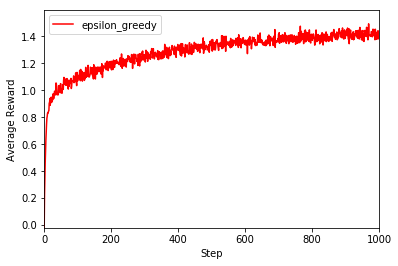

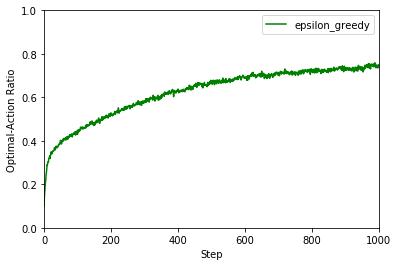

In [11]:
exp = k_AB_Experiment(number_of_agents = 2000, 
                      agent_to_bandit_mode = 'one_to_one', 
                      decision_mode = 'epsilon_greedy',
                      update_mode = 'constant_step', 
                      problem_mode = 'non_stationary')

exp.run(1000)
exp.report(0, 1000)